## Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms # pytorch component for data prepration
import matplotlib.pyplot as plt
import time
import os
import copy

from google.colab import files
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

plt.ion()   # interactive mode

## Data transformation

In [ ]:
# Define transformation that you wish to apply on image
#
# Data augmentation and normalization for training
#      Data augmentation adding slightly modifiaction in existing data or
#      newly created synthetic data from existing data.
#
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([ # Composes several transforms together
        transforms.RandomResizedCrop(224), # Crop the given image to random size and aspect ratio
        transforms.RandomHorizontalFlip(), # Horizontally flip the given image randomly
                                           # with a given probability, default 0.5
        transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [ ]:
data_dir = 'Skin-cancer'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Show some examples

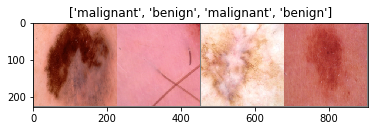

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define model - using pre-trained model (Resnet18)

Ref: https://arxiv.org/pdf/1611.05431.pdf

In [ ]:
# load the pre-trained Resnet19
model_ft = models.resnet18(pretrained=True)

In [ ]:
# show orignial model structure
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
# replace the last fully connect layer
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

In [ ]:
# show updated model structure
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [ ]:
# define loss function, optimizer

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Define training procedure

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    loss_history = []
    train_history = []
    val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                loss_history.append(epoch_loss)
                train_history.append(epoch_acc)
            else:
                val_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, train_history, val_history

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Model training

In [ ]:
num_epochs = 10
model_ft, loss_history, train_history, val_history = train_model(model_ft,
                                                                 criterion,
                                                                 optimizer_ft,
                                                                 exp_lr_scheduler,
                                                                 num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.6186 Acc: 0.7220
val Loss: 0.4394 Acc: 0.8273

Epoch 1/9
----------
train Loss: 0.6134 Acc: 0.7330
val Loss: 0.5630 Acc: 0.7455

Epoch 2/9
----------
train Loss: 0.5467 Acc: 0.7675
val Loss: 0.3240 Acc: 0.8379

Epoch 3/9
----------
train Loss: 0.4718 Acc: 0.7983
val Loss: 0.3719 Acc: 0.8182

Epoch 4/9
----------
train Loss: 0.4459 Acc: 0.8062
val Loss: 0.3496 Acc: 0.8515

Epoch 5/9
----------
train Loss: 0.4395 Acc: 0.8111
val Loss: 0.3404 Acc: 0.8424

Epoch 6/9
----------
train Loss: 0.4049 Acc: 0.8290
val Loss: 0.3469 Acc: 0.8409

Epoch 7/9
----------
train Loss: 0.3314 Acc: 0.8502
val Loss: 0.2897 Acc: 0.8576

Epoch 8/9
----------
train Loss: 0.3065 Acc: 0.8620
val Loss: 0.2743 Acc: 0.8727

Epoch 9/9
----------
train Loss: 0.3048 Acc: 0.8612
val Loss: 0.2915 Acc: 0.8500

Training complete in 55m 29s
Best val Acc: 0.872727


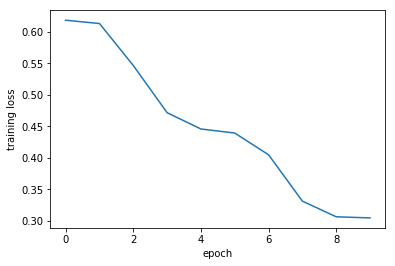

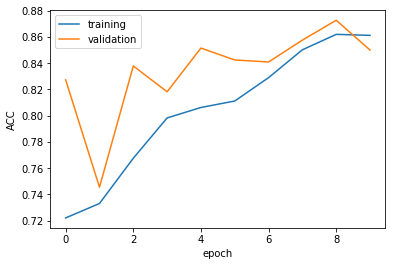

In [ ]:
# visualize training process
import matplotlib.pyplot as plt

epochs = list(range(num_epochs))

plt.plot(epochs, loss_history)
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.show()


plt.plot(epochs, train_history, label='training')
plt.plot(epochs, val_history, label='validation')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend()
plt.show()


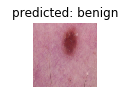

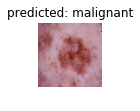

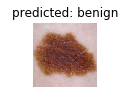

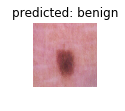

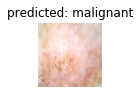

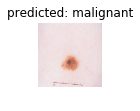

In [ ]:
visualize_model(model_ft)

## Model peformance

In [ ]:
correct = 0
total = 0

predicted_labels = []
true_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)

        predicted_labels += predicted.data.numpy().tolist()
        true_labels += labels.data.numpy().tolist()

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 87 %


In [ ]:
from sklearn.metrics import classification_report
# show a nicely formatted classification report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       360
           1       0.90      0.81      0.85       300

    accuracy                           0.87       660
   macro avg       0.88      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

# Label mapping by category (flat for prediction)
label_map = {
    0: "Superficial spreading melanoma",
    1: "Nodular melanoma",
    2: "Lentigo maligna melanoma",
    3: "Basal cell carcinoma",
    4: "Squamous cell carcinoma",
    5: "Actinic keratosis",
    6: "Melanocytic nevus (mole)",
    7: "Dermatofibroma",
    8: "Seborrheic keratosis",
    9: "Vascular lesions (hemangiomas)",
    10: "Fungal infections (tinea)",
    11: "Viral warts",
    12: "Bacterial infections",
    13: "Eczema",
    14: "Psoriasis",
    15: "Acne",
    16: "Rosacea"
}

# Preprocessing steps for input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load image and preprocess
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Load the trained model
def load_model(model_path, device='cpu'):
    model = models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, len(label_map))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Predict top 5 classes with probabilities
def predict_top5(image_tensor, model, device='cpu'):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs[0], dim=0)
        top5_probs, top5_indices = torch.topk(probabilities, 5)
        results = [(label_map[idx.item()], prob.item()) for idx, prob in zip(top5_indices, top5_probs)]
        return results

# Example usage
if __name__ == "__main__":
    image_path = "0_Skin.jpg"  # Replace with your image path
    model_path = "enhanced_skin_lesion_classifier2.pth"  # Replace with your model path
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image_tensor = load_image(image_path)
    model = load_model(model_path, device)
    predictions = predict_top5(image_tensor, model, device)

    print("Top 5 Predicted Conditions:")
    for condition, prob in predictions:
        print(f"{condition}: {prob:.2%}")


In [ ]:
# --- IMPORTS ---
from google.colab import files
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# --- 1. UPLOAD IMAGE + METADATA ---
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"✅ Uploaded file: {filename}")
    image_path = filename

body_part_options = ['Face', 'Arm', 'Back', 'Chest', 'Leg', 'Scalp', 'Abdomen', 'Other']
body_part_dropdown = widgets.Dropdown(options=body_part_options, description='Body Part:', disabled=False)
display(body_part_dropdown)

timeline_options = ['Appeared recently', 'Present for months', 'Present for years', 'Changing recently', 'No change']
timeline_dropdown = widgets.Dropdown(options=timeline_options, description='Timeline:', disabled=False)
display(timeline_dropdown)

def get_metadata():
    selected_body_part = body_part_dropdown.value
    selected_timeline = timeline_dropdown.value
    return selected_body_part, selected_timeline

# --- 2. UPLOAD MODEL ---
uploaded = files.upload()
for filename in uploaded.keys():
    model_path = filename

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_transfer_learning(num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = setup_transfer_learning()
model = model.to(device)

checkpoint = torch.load(model_path, map_location=device)
model = setup_transfer_learning(num_classes=10)  # Initialize your model architecture again
model.load_state_dict(checkpoint)  # Now load only the weights into the initialized model
model.eval()


# --- 3. IMAGE TRANSFORM + INFERENCE ---
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    top_probs, top_indices = torch.topk(probs, 2)

# class_names = [
#     'Melanoma',
#     'Nevus',
#     'Basal Cell Carcinoma',
#     'Actinic Keratosis',
#     'Benign Keratosis',
#     'Dermatofibroma',
#     'Vascular Lesion',
#     'Squamous Cell Carcinoma',
#     'Seborrheic Keratosis',
#     'Lentigo'
# ]
# After making the predictions and showing the results:

print("\n🧪 Prediction Result:")
body_part, timeline = get_metadata()
print(f"📍 Body Part: {body_part}")
print(f"🕒 Timeline: {timeline}")

# Display the top predictions
print("\n🔍 Top Predictions:")
for prob, idx in zip(top_probs[0], top_indices[0]):
    predicted_class = class_names[idx.item()]
    print(f"{predicted_class}: {prob.item()*100:.2f}% probability")

    # Provide care recommendation based on the prediction
    if predicted_class == "Melanoma" or predicted_class == "Squamous Cell Carcinoma":
        print("⚠️ It appears that the lesion is potentially malignant. Please reach out to your healthcare provider for further evaluation.")
    elif predicted_class == "Basal Cell Carcinoma":
        print("⚠️ This could be a type of skin cancer. It's recommended to consult with your provider.")
    else:
        print("👍 This appears to be a benign lesion, but if you notice any changes, it's still a good idea to consult with a provider.")
